In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # библиотека для построения графиков
import seaborn as sns # библиотека для построения графиков

from sklearn import preprocessing, decomposition, manifold, model_selection, pipeline, cluster, datasets, mixture, metrics

from sklearn import linear_model as lm
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_curve, precision_score, roc_auc_score, f1_score

from sklearn.svm import LinearSVC, SVC

from IPython.display import Image

%matplotlib inline 

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_task_AD_ML/Task5_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_task_AD_ML/Task5_train.csv')

In [ ]:
data_train

,Unnamed: 0,index,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,...,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120
0,0,1059,0.146442,-3.375223,-10.380706,14.488187,42.433324,3.567948,-0.407952,-0.778009,-6.806665,0.304032,-27.311202,0.044763,-12.219338,-26.131685,4.005900,-0.478898,-6.679827,-0.690835,10.246254,-12.260792,0.087844,-31.996789,3.847995,-4.436029,-9.731909,-16.749329,-31.368296,-9.842283,-1.413273,-6.922678,-0.365034,-24.082258,6.696559,-1.658635,-57.541538,-16.276406,-22.485147,-6.431709,...,8.829209,-25.392934,2.574772,3.071308,8.477072,3.126973,19.976854,-2.074319,11.725706,-10.616143,1.331708,-14.768991,18.655160,-5.195715,15.542703,16.438752,-1.150339,-18.673674,-0.032026,0.303814,-0.994723,-10.584504,4.470097,0.184578,22.764649,-10.287604,0.107596,-7.474190,6.463507,0.720939,17.842198,-4.235979,-3.090988,-16.809032,-17.604523,-12.415682,-11.636028,-0.784215,-18.296195,15.515276
1,1,2045,0.488790,-3.071530,-22.425550,4.060582,19.652617,-7.134599,-7.201065,-0.175808,33.717211,-2.658686,3.295941,-0.151478,-37.434847,31.755507,1.492768,6.565600,0.039224,-2.389612,-19.878323,-14.444823,2.088682,-24.729351,10.788288,-27.741025,-8.391343,17.700096,-39.782367,-0.693720,17.355775,9.112603,-0.067070,-41.505011,6.209684,-0.126423,-78.555606,5.405039,-3.932334,17.321680,...,47.672348,8.117842,7.498484,-2.073629,11.908600,-1.815837,3.879635,-27.217717,12.554560,13.514449,-0.912442,-13.487288,-3.476615,4.092859,31.890049,-26.838297,1.765843,-11.126551,-0.305667,0.235033,-2.035636,-18.459598,-5.766898,-6.941736,-14.227557,-11.042686,-13.184774,-1.929972,-1.265516,-3.438024,10.305863,-0.077751,-16.040180,-2.143216,4.328842,33.620275,10.241176,-13.356787,-46.001087,22.231516
2,2,3468,0.209077,2.512906,11.003405,13.591295,-6.510962,-1.534895,-3.742965,0.455756,30.643341,-0.766931,0.431625,-0.683775,-32.766321,-3.774504,0.548289,2.512394,4.274429,-10.163668,-1.347850,2.994314,-5.836261,-30.925108,-1.897290,-8.882311,-5.290201,3.580727,-34.594968,-4.903294,22.797472,8.944205,0.739087,-28.484622,-0.728392,-0.206562,-15.961145,27.334702,-17.871890,4.902305,...,1.862317,10.550962,2.197280,0.586043,7.941565,0.805262,-11.733989,-1.483040,-17.520775,-2.394603,-2.243096,-55.330818,-30.670222,-1.404774,17.086274,11.797778,5.188913,0.169370,1.115942,1.541386,-0.132643,-16.499650,11.462400,-11.392735,-16.719483,-11.265641,5.842610,-26.770341,10.200796,-2.082866,2.116266,-6.212255,-30.838870,2.446050,-11.532322,34.203352,-6.748755,-4.030347,-0.224291,-9.694489
3,3,3877,17.599400,6.076552,74.631520,23.134616,-4.776874,8.182656,9.169928,-1.903280,-36.956957,23.766993,4.043723,-0.133135,47.768304,22.961914,-18.479127,2.903766,-0.339558,9.036974,-2.903821,-17.125368,7.641905,24.305344,-0.209348,8.501771,-1.393947,3.478882,52.522372,-8.939272,-1.991746,-11.773068,0.214652,23.723468,-1.517544,-2.442183,0.118142,16.671964,2.460246,5.242463,...,25.875753,28.453944,4.864754,0.781273,-4.062692,2.655865,-0.091593,-4.893682,18.995651,9.870306,-0.359895,-45.025594,-10.570789,2.739162,21.398234,-21.905491,15.551713,11.641065,0.249495,-7.049112,0.707917,4.050590,-6.286031,-19.995874,18.077953,2.519473,-13.950086,-2.987323,6.598104,2.493349,2.591505,0.547467,-10.293424,-0.905006,-29.186643,-30.349566,-16.402989,8.171630,41.717575,4.183015
4,4,1702,0.621051,0.485973,-15.891477,34.422507,-3.772496,-3.618411,3.278072,-0.229292,-11.056757,40.921275,-24.529393,0.327063,17.324143,-1.003864,-8.633182,12.699929,-3.899763,16.007386,24.048765,-29.925545,-17.730068,15.637763,-0.912579,9.865434,-3.920289,-3.830797,14.203856,-7.756311,-9.637838,-30.788808,0.934511,15.065174,-5.286956,-0.281409,6.116271,37.122409,13.585866,-8.069912,...,-26.813753,-8.526535,-6.537047,1.178490,14.116126,-7.190352,24.784732,11.920471,3.141651,-10.859938,0.76286

---
Разведочный анализ


---




In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Columns: 123 entries, Unnamed: 0 to X120
dtypes: float64(121), int64(2)
memory usage: 2.5 MB


Как видно, столбец unnamed: 0 просто повторяет индексы - удалим его.

In [ ]:
data_train.describe()

,Unnamed: 0,index,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,...,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120
count,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,...,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000,2625.000000
mean,1312.000000,2519.459048,1.978995,0.071205,-0.203112,-0.061825,0.245741,-0.019128,-0.070265,0.020473,-0.979943,-0.347381,-0.351325,-0.009280,-0.400627,0.485705,0.068443,0.026245,-0.066325,-0.009504,-0.040499,-0.240676,-0.009501,-0.653416,-0.024926,-0.262021,0.241467,0.345095,-0.320778,-0.199374,-0.332440,0.069243,0.039380,-0.213342,-0.079833,-0.067621,-0.260791,-0.629292,-0.725520,0.371151,...,-0.258569,-0.230264,0.153506,-0.047516,0.264002,-0.431944,-0.145937,-0.599884,0.060499,-0.203339,0.039240,-0.484902,-0.430209,0.135407,-0.323408,-0.114250,0.164985,-0.228758,0.004604,-0.052641,-0.035550,-0.034597,-0.111744,0.214425,-0.223975,0.103839,0.123026,-0.297366,0.141337,-0.018694,0.007518,-0.145303,-0.645051,-0.168824,0.365838,-0.171041,0.617278,-0.074850,0.430315,0.096581
std,757.916552,1430.302305,3.232856,9.252400,31.497308,21.248884,17.946161,4.432176,4.835129,1.752829,24.593667,17.318660,26.019687,0.561842,32.824431,23.569678,6.853187,7.028558,4.851945,8.501739,15.872728,13.351385,9.822673,17.056206,4.932686,11.915990,10.485253,13.999996,23.771467,7.594261,18.583512,12.571172,1.682464,22.156593,3.997039,2.061769,30.219217,26.107415,22.888867,9.375661,...,25.010670,17.347960,8.322962,1.927912,10.523885,8.515020,18.831649,18.371839,23.364628,13.922276,3.323720,33.120564,22.239829,14.890354,31.963083,14.196878,14.168195,13.061515,0.702789,3.274860,0.973916,12.864920,10.960832,13.876003,39.387962,6.266783,12.331820,24.912408,6.107304,2.719517,12.201787,5.561683,32.674976,20.352540,16.638686,25.681628,22.572198,6.696407,28.718146,16.212618
min,0.000000,0.000000,0.021393,-35.484333,-112.821002,-76.372344,-59.385102,-17.243207,-14.784950,-6.264596,-102.506609,-65.857841,-83.671835,-1.821751,-128.602852,-83.334191,-21.685103,-24.643084,-18.076344,-28.125123,-51.195722,-44.179983,-31.709307,-63.500565,-15.678984,-43.874326,-34.764684,-49.328019,-85.079821,-25.025288,-64.117480,-40.681708,-6.646886,-71.108891,-12.221052,-7.373032,-100.318196,-81.555896,-86.836678,-29.658492,...,-89.605564,-58.680553,-24.788311,-6.216957,-44.690202,-31.046868,-67.435484,-60.459108,-82.957709,-48.553034,-11.294388,-93.268762,-85.980830,-47.567458,-104.315325,-52.204796,-48.183522,-48.683595,-2.740835,-14.121725,-3.271335,-43.573115,-34.365379,-51.878095,-117.332854,-20.943961,-43.585883,-83.482854,-20.784464,-9.143214,-39.575647,-17.966558,-105.212720,-63.699492,-60.703706,-81.598101,-86.506053,-22.870528,-104.778210,-58.422769
25%,656.000000,1291.000000,0.438402,-6.217600,-20.784518,-14.164826,-11.817839,-2.925582,-3.454548,-1.142338,-17.670657,-11.962469,-18.703863,-0.399171,-22.451122,-15.710742,-4.388663,-4.914220,-3.333569,-5.634724,-11.257519,-9.024187,-6

In [ ]:
data_train.drop(['Unnamed: 0'], axis=1, inplace=True)

Проверим столбец index

In [ ]:
len(data_train['index'].unique())

2625

Все строки в столбце уникальны, стоят в разном порядке, думаю, он тоже нам не нужен.

In [ ]:
data_train.drop(['index'], axis=1, inplace=True)

In [ ]:
data_train_Y = data_train['Y'] #целевая переменная
data_train_X = data_train.loc[:, 'X1':] #признаки

Посмотрим, какие признаки между собой сильно коррелируют (по шкале Чаддока >= |0.9|)

In [ ]:
corr_matr = data_train_X.corr().abs()

In [ ]:
upper = corr_matr.where(np.triu(np.ones(corr_matr.shape), k=1).astype(np.bool))

In [ ]:
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

In [ ]:
to_drop #список пуст, значит, сильно коррелирующих столбцов между собой нет.

[]

In [ ]:
data_train_X.drop(data_train_X[to_drop], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Проверка на наличие пропущенных значений

In [ ]:
data_train_X.isnull().sum().unique()

array([0])

Пропущенных значений нет

Построим boxplot

Text(0.5, 1.0, 'Тренировочный набор non scaled')

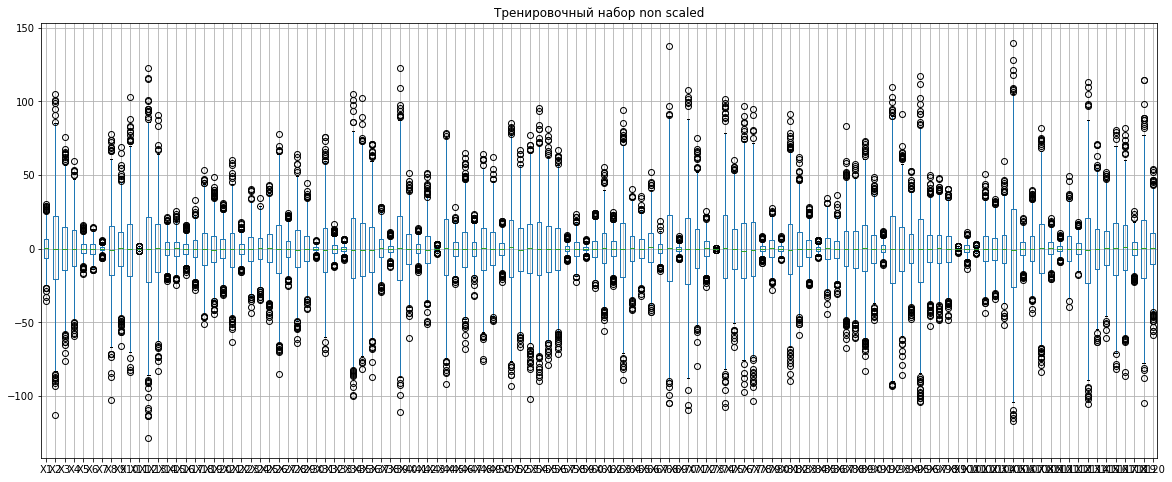

In [ ]:
g = data_train_X.boxplot(figsize = (20, 8))
g.set_title('Тренировочный набор non scaled')

Видно, что необходимо провести шкалирование. А еще заметны выбросы.

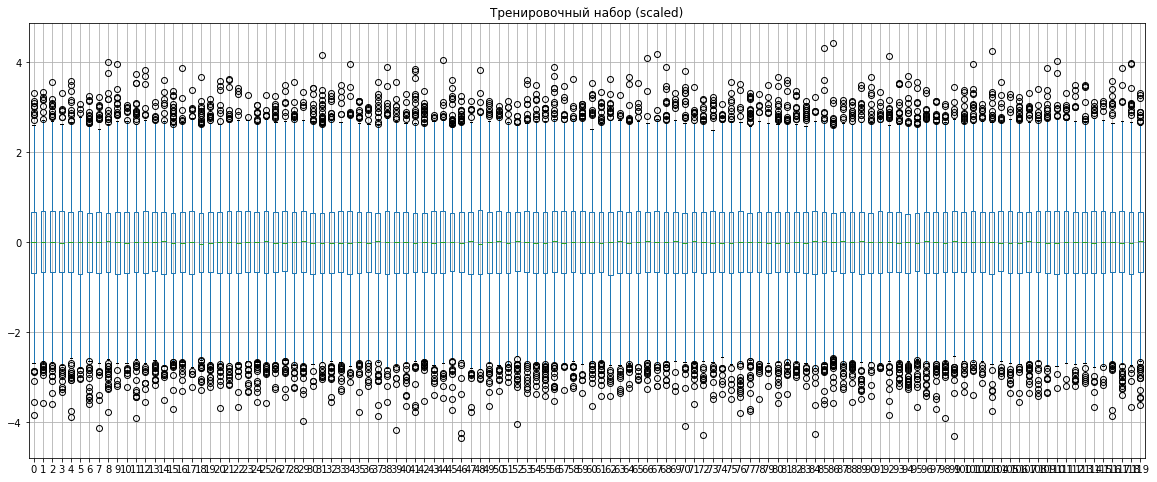

In [ ]:
data_train_X_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(data_train_X))
gsc = data_train_X_scaled.boxplot(figsize = (20, 8))
gsc.set_title('Тренировочный набор (scaled)');

Посмотрим на распределение значений параметров (не шкалированные)

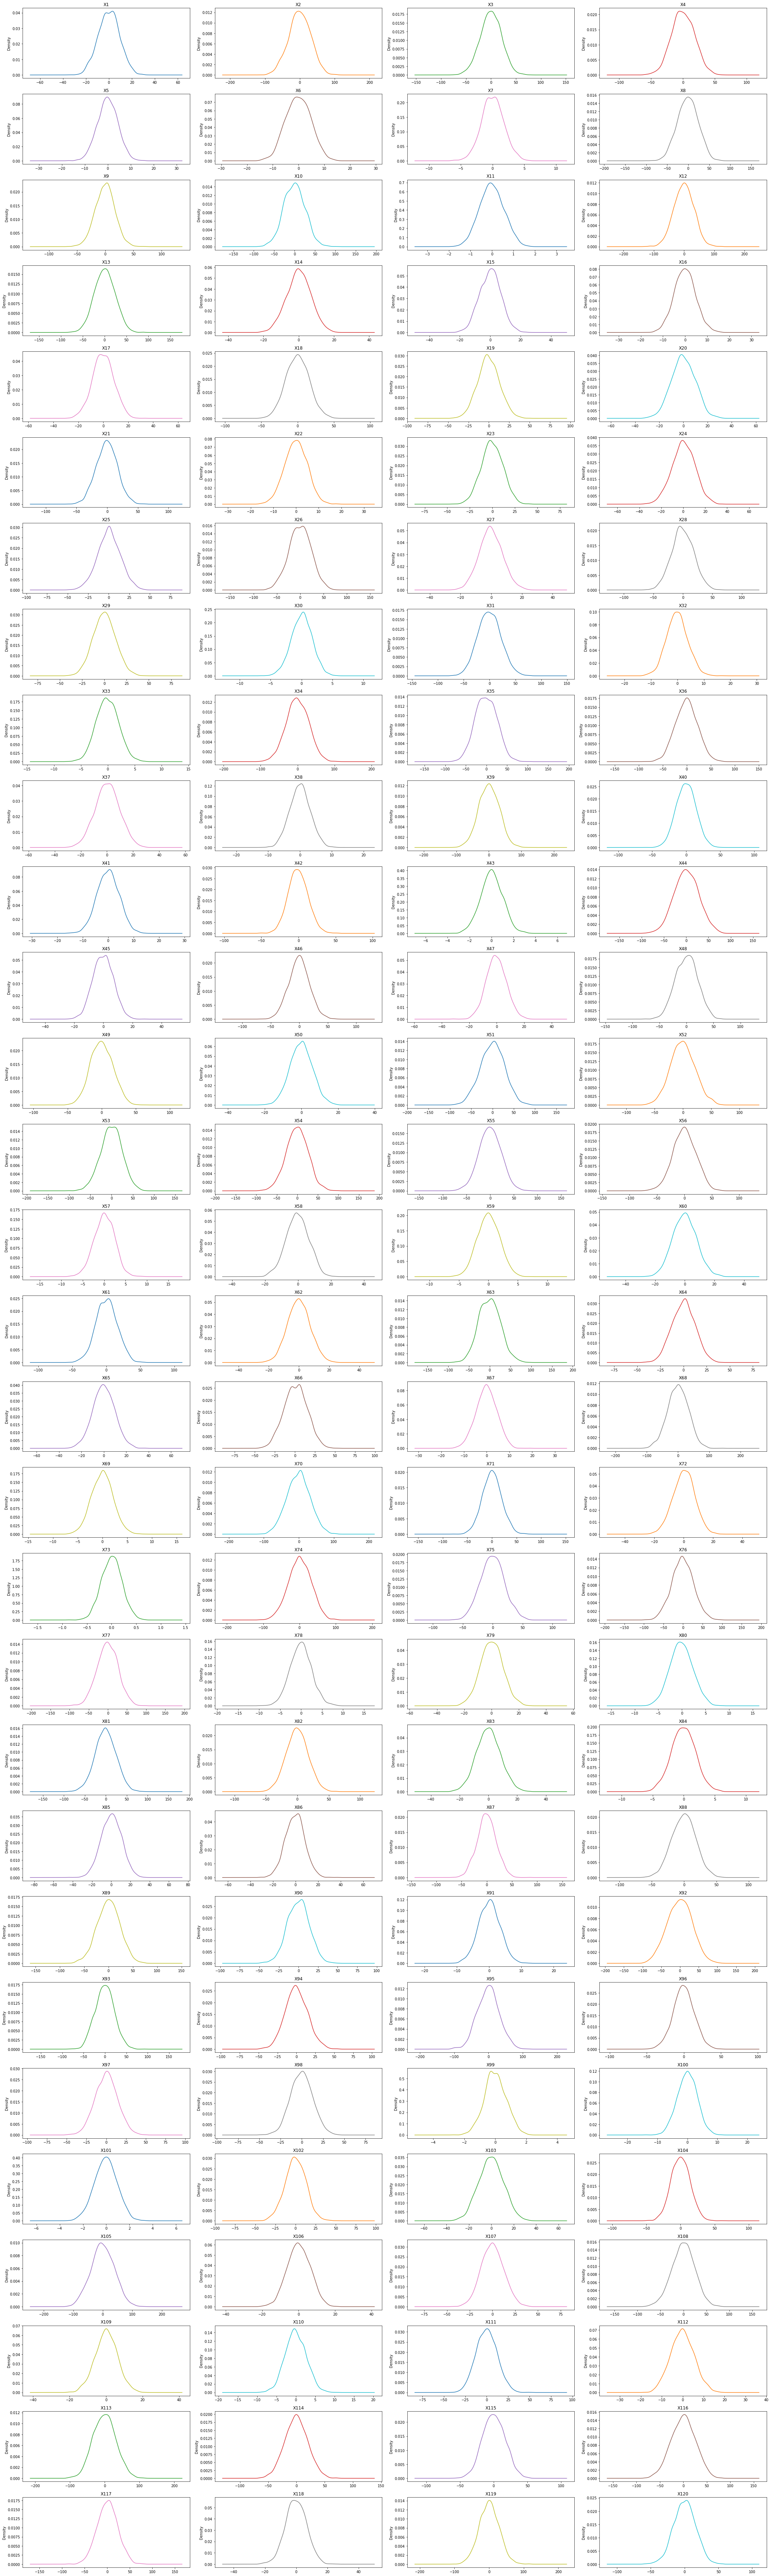

In [ ]:
_ = data_train_X.iloc[:,:].plot(kind='kde', subplots=True, layout=(30,4), sharex=False, 
                         sharey=False, figsize=[30,100], legend = False,
                         title = data_train_X.columns.values.tolist()[:])
plt.tight_layout();

Посмотрим на распределение значений параметров (шкалированные)



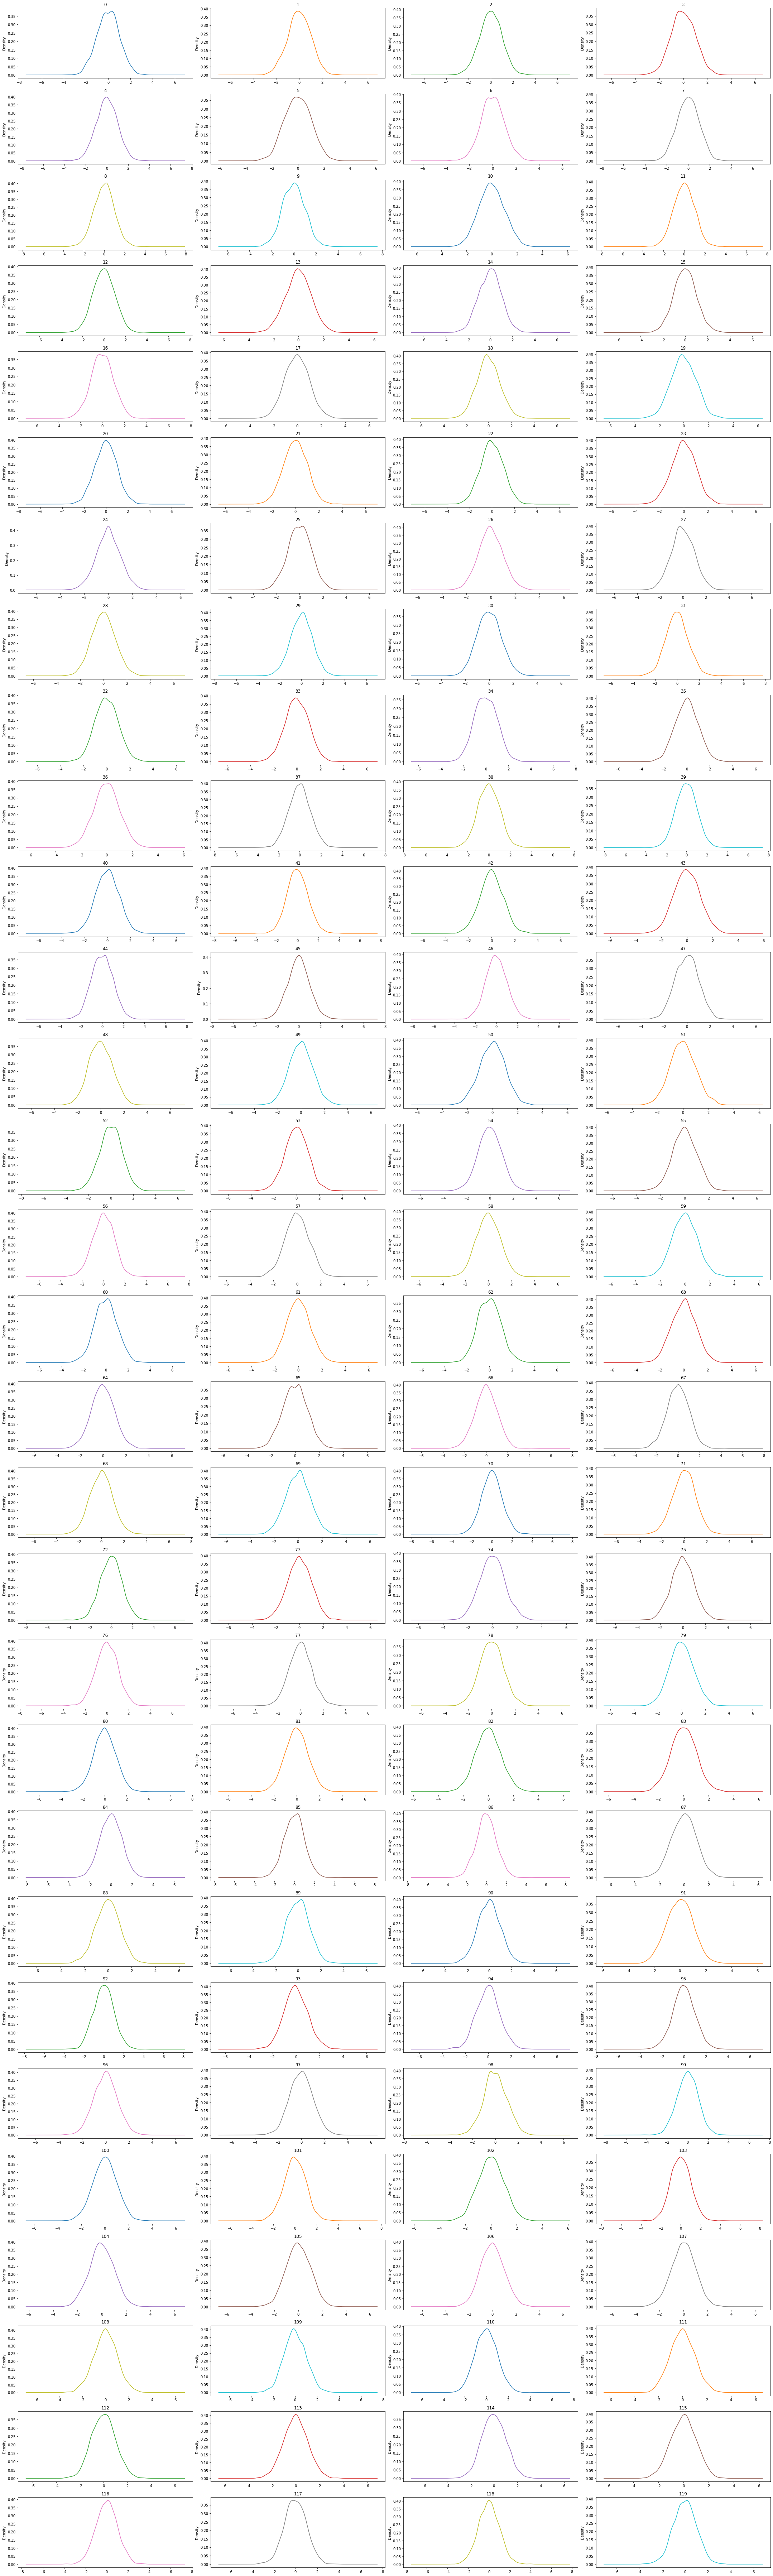

In [ ]:
_ = data_train_X_scaled.iloc[:,:].plot(kind='kde', subplots=True, layout=(30,4), sharex=False, 
                         sharey=False, figsize=[30,100], legend = False,
                         title = data_train_X_scaled.columns.values.tolist()[:])
plt.tight_layout();

Все распределения являются нормальными. Надо проверить теперь целевой признак.

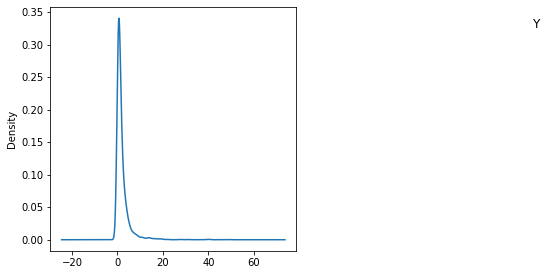

In [ ]:
data_train_Y.plot(kind='kde', subplots=True, layout=(4,4), sharex=False, 
                         sharey=False, figsize=[15,15], legend = False,
                         title = 'Y')
plt.tight_layout(); #Тут не похоже на нормальное распределение. Это плохо, можно попробовать логарифмирование.

In [ ]:
data_train_Y_log = np.log(data_train_Y)


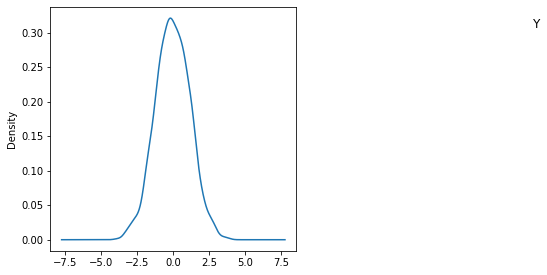

In [ ]:
data_train_Y_log.plot(kind='kde', subplots=True, layout=(4,4), sharex=False, 
                         sharey=False, figsize=[15,15], legend = False,
                         title = 'Y')
plt.tight_layout(); #Колокол.

In [ ]:
X_train = data_train_X_scaled
Y_train = data_train_Y_log
X_test = preprocessing.StandardScaler().fit_transform(data_test.loc[:, 'X1':])
Y_test = np.log(data_test['Y'])

In [ ]:
from sklearn.svm import LinearSVR
from sklearn import metrics

In [ ]:
regr = LinearSVR()
model = regr.fit(X=X_train, y=Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
model.predict(X_test)

array([-1.81774786, -0.53095487, -1.59345774, ...,  1.05239118,
       -1.42463286, -1.63557991])

In [ ]:
metrics.r2_score(Y_test, model.predict(X_test))

0.9897262481782184

LinearSVR показала довольно неплохой результат

In [ ]:
import pickle

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))